# Estimating Proportions

In [1]:
include("utils.jl"); using .Utils
checkpkgs("Plots", "Distributions")

In [2]:
using Plots

## The Euro problem

## The Binomial Distribution

In [3]:
using Distributions

n = 2
p = 0.5
k = 1

pdf(Binomial(n, p), k)

0.49999999999999994

In [4]:
ks = 0:n

ps = pdf.(Binomial(n,p), ks)
ps

3-element Vector{Float64}:
 0.24999999999999994
 0.49999999999999994
 0.24999999999999994

In [5]:
include("empiricaldist.jl"); using .EmpiricalDist

In [6]:
pmf_k = Pmf(ps, ks)
pmf_k

┌───┬───────┐
│   │ probs │
├───┼───────┤
│ 0 │  0.25 │
│ 1 │   0.5 │
│ 2 │  0.25 │
└───┴───────┘


In [7]:
"""Make a binomial Pmf."""
function make_binomial(n, p)
    ks = 0:n
    ps = pdf.(Binomial(n,p), ks)
    return Pmf(ps, ks, name = "binomial")
end
make_binomial(;n,p) = make_binomial(n,p)

make_binomial (generic function with 2 methods)

In [8]:
pmf_k = make_binomial(n=250, p=0.5);

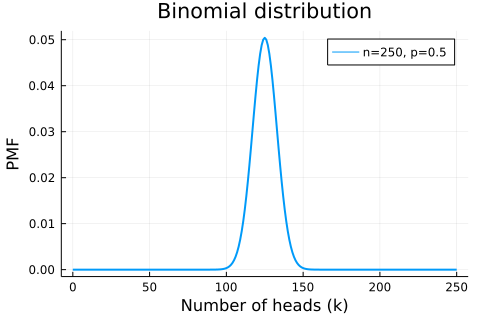

In [9]:
plot(pmf_k, label="n=250, p=0.5")
xlabel!("Number of heads (k)")
ylabel!("PMF")
title!("Binomial distribution")

In [10]:
maxprob(pmf_k)

125

In [11]:
pmf_k[125]

0.05041221314731098

In [12]:
pmf_k[140]

0.00835718172491837

In [13]:
# prob_ge is already defined in empiricaldist.jl, so renaming this function
function prob_ge(pmf, threshold)
    ge = (pmf.qs .>= threshold)
    total = sum(pmf[ge])
    return total
end

prob_ge (generic function with 1 method)

In [14]:
prob_ge(pmf_k, 140)

0.03321057562002172

In [15]:
EmpiricalDist.prob_ge(pmf_k, 140)

0.03321057562002172

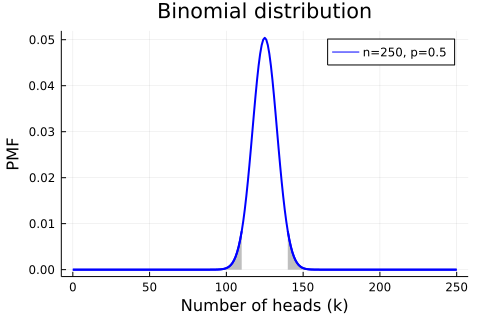

In [16]:
plot(pmf_k, label="n=250, p=0.5", color=:blue, fill_below=110, fill_above=140)

xlabel!("Number of heads (k)")
ylabel!("PMF")
title!("Binomial distribution")

In [17]:
prob_le(pmf_k, 110)

0.033210575620021734

## Bayesian Estimation

In [18]:
hypos = range(0, 1, length=101)
prior = Pmf(1, hypos);

In [19]:
likelihood_heads = hypos
likelihood_tails = 1 .- hypos;

In [20]:
likelihood = Dict(
     'H' => likelihood_heads,
     'T' => likelihood_tails
);

In [21]:
dataset='H'^140*'T'^110;

In [22]:
"""Update pmf with a given sequence of H and T."""
function update_euro!(pmf, dataset)
    for data in dataset
        pmf .*= likelihood[data]
    end
    normalize!(pmf)
end

update_euro!

In [23]:
posterior = copy(prior)
update_euro!(posterior, dataset);

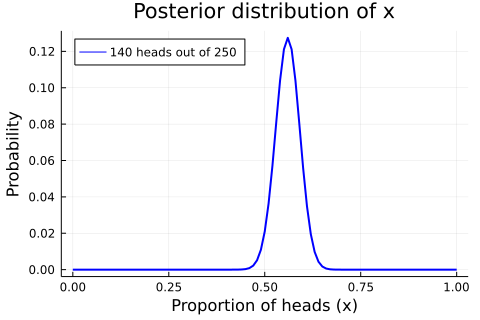

In [24]:
plot(posterior, label="140 heads out of 250", title="Posterior distribution of x", color=:blue, legend=:topleft)
xlabel!("Proportion of heads (x)")
ylabel!("Probability")

In [25]:
maxprob(posterior)

0.56

## Triangle Prior

In [26]:
uniform = Pmf(1, hypos, name = "uniform")
normalize!(uniform)

101.0

In [27]:
ramp_up = collect(0:49)
ramp_down = collect(50:-1:0)
a = vcat(ramp_up, ramp_down)

triangle = Pmf(a, hypos, name = "triangle")
normalize!(triangle)

2500.0

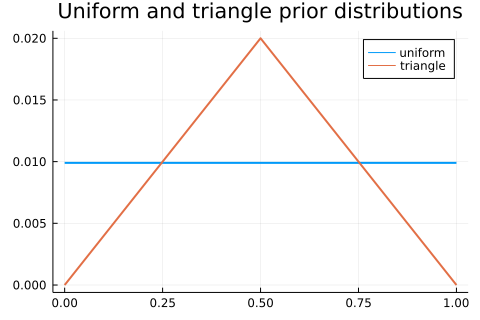

In [28]:
plot(uniform)
plot!(triangle)
title!("Uniform and triangle prior distributions")

In [29]:
update_euro!(uniform, dataset);
update_euro!(triangle, dataset);

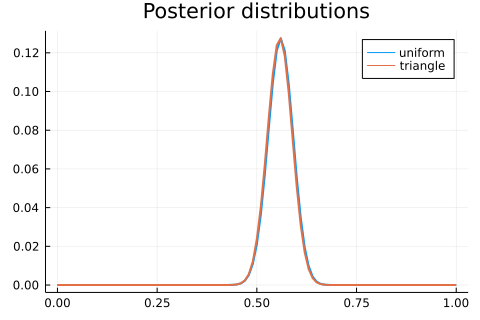

In [30]:
plot(uniform)
plot!(triangle)
title!("Posterior distributions")

## The Binomial Likelihood Function

In [31]:
"""Update pmf using the binomial distribution."""
function update_binomial!(pmf, data)
    k, n = data
    xs = pmf.qs
    likelihood = pdf.(Binomial.(n, xs), k)
    pmf .*= likelihood
    normalize!(pmf)
end

update_binomial!

In [32]:
uniform2 = Pmf(1, hypos, name="uniform2")
data = 140, 250
update_binomial!(uniform2, data);

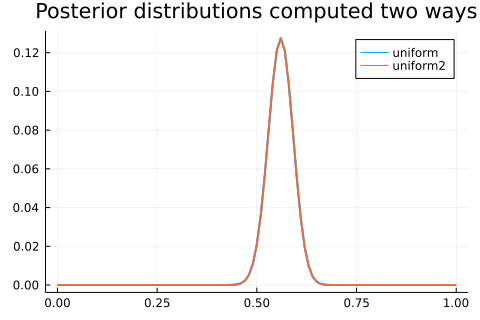

In [33]:
plot(uniform)
plot!(uniform2)
title!("Posterior distributions computed two ways")

In [34]:
isapprox(uniform, uniform2)

true

## Bayesian Statistics

## Summary

## Exercises

In [35]:
# 4.1
hypos = range(0.1, 0.4, length=101)
prior = Pmf(1, hypos);

In [36]:
likelihood = Dict(
    'Y' => hypos,
    'N' => 1 .- hypos
);

In [37]:
dataset = 'Y'^25 * 'N'^75;

In [38]:
for data in dataset
    prior .*= likelihood[data]
end
normalize!(prior)

1.3596964206970504e-23

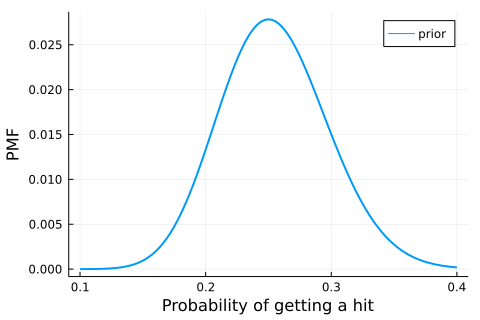

In [39]:
plot(prior, label="prior")
xlabel!("Probability of getting a hit")
ylabel!("PMF")

In [40]:
# Solution

posterior = copy(prior)

for data in "YYY"
    posterior .*= likelihood[data]
end

normalize!(posterior);

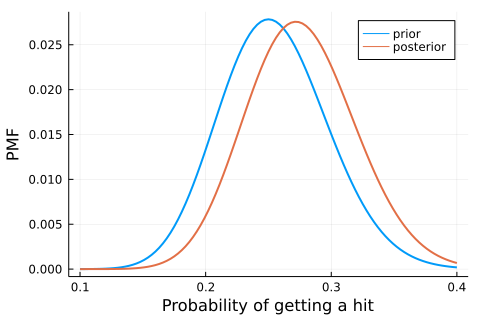

In [41]:
plot(prior, label="prior")
plot!(posterior, label="posterior")
xlabel!("Probability of getting a hit")
ylabel!("PMF")

In [42]:
# Solution
maxprob(prior)

0.25

In [43]:
maxprob(posterior)

0.271

In [44]:
# 4.2
hypos = range(0.0, 1.0, length=101)
prior = Pmf(1, hypos);

In [45]:
likelihood = Dict(
    'Y' => 0.5 .+ hypos./2,
    'N' => (1 .- hypos)./2
);

In [46]:
dataset = 'Y' ^ 80 * 'N' ^ 20

posterior = copy(prior)

for data in dataset
    posterior .*= likelihood[data]
end

normalize!(posterior)

3.694513913396693e-21

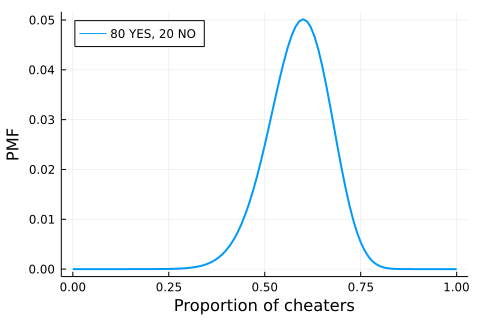

In [47]:
# Solution

plot(posterior, label="80 YES, 20 NO", legend=:topleft)
xlabel!("Proportion of cheaters")
ylabel!("PMF")

In [48]:
argmax(posterior)

0.6

In [49]:
# 4.3
function update_unreliable!(pmf, dataset, y)
    likelihood = Dict(
        'H' => (1-y) .* hypos .+ y .* (1 .- hypos),
        'T' => y .* hypos .+ (1-y) .* (1 .- hypos)
    )
    for data in dataset
        pmf .*= likelihood[data]
    end

    normalize!(pmf)
end

update_unreliable! (generic function with 1 method)

In [50]:
hypos = range(0, 1, length=101)
prior = Pmf(1, hypos)
dataset = 'H' ^ 140 * 'T' ^ 110

posterior00 = copy(prior)
update_unreliable!(posterior00, dataset, 0.0)

posterior02 = copy(prior)
update_unreliable!(posterior02, dataset, 0.2)

posterior04 = copy(prior)
update_unreliable!(posterior04, dataset, 0.4);

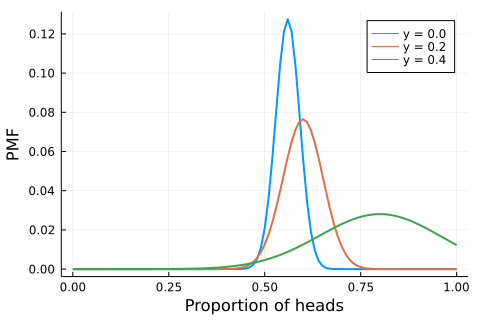

In [51]:
plot(posterior00, label="y = 0.0")
plot!(posterior02, label="y = 0.2")
plot!(posterior04, label="y = 0.4")
xlabel!("Proportion of heads")
ylabel!("PMF")

In [52]:
# Solution

argmax(posterior00), argmax(posterior02), argmax(posterior04)

(0.56, 0.6, 0.8)

In [53]:
#4.4

hypos = range(0.1, 0.4, length=101)
prior = Pmf(1, hypos);

In [54]:
# Here's a specific version for n=2 shots per test

x = hypos
likes = hcat((1 .- x) .^4, (2x .*(1 .- x)).^ 2, x .^ 4)

likelihood = sum(likes, dims=2)

# likelihood is a 101x1 matrix. We need to convert it to a vector:
likelihood = dropdims(likelihood, dims=2);

In [55]:
# Here's a more general version for any n shots per test

sum_and_dropdims(l) = dropdims(sum(l, dims=2), dims=2) # helper
n = 2
likes2 = [pdf(Binomial(n,p), k)^2 for p in x,  k in 0:n]
likelihood2 = sum_and_dropdims(likes);

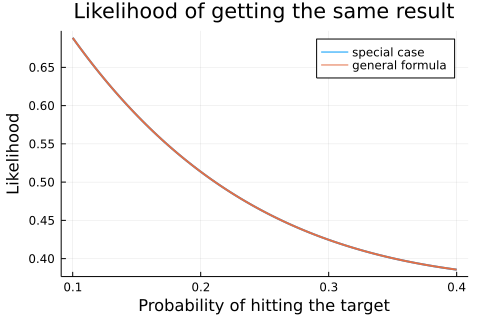

In [56]:
plot(x, likelihood, label="special case")
plot!(x, likelihood2, label="general formula", legend=:topright)
xlabel!("Probability of hitting the target")
ylabel!("Likelihood")
title!("Likelihood of getting the same result")

In [57]:
# Solution

posterior = prior .* likelihood
normalize!(posterior)

49.12962799838001

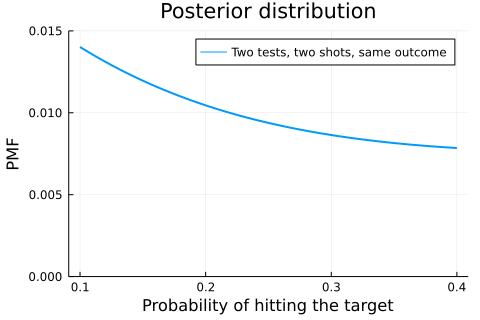

In [58]:
# Solution

plot(posterior, label="Two tests, two shots, same outcome",
    xlabel="Probability of hitting the target", ylabel="PMF",
    title="Posterior distribution", ylims=(0, 0.015))